In [198]:
%load_ext autoreload
%autoreload 2
import gym
from gym import spaces
import numpy as np
from gym_examples.envs.dubins_car import DubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [743]:
#generate data

env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(1000):
    state = env.reset()
    for action in range(env.action_space.n):
        X.append(state)
        r = env.sample(state, action, 0)
        y.append(r)

X = np.array(X)
y = np.array(y)



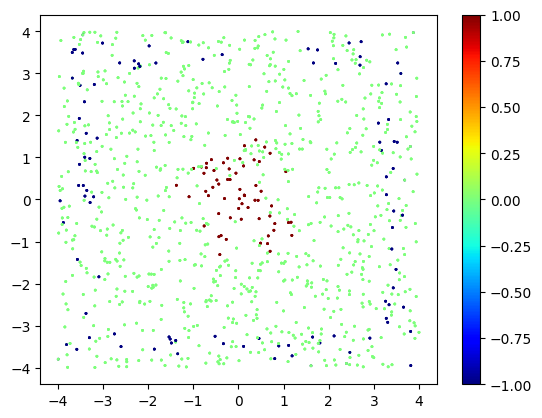

In [709]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Plot...
plt.scatter(X[:,0], X[:,1], c=y, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
#plt.show()
plt.savefig('env.png')

In [285]:
np.min(y)

0

In [311]:
np.random.shuffle(X)

In [748]:
#params are defined *implicitly* in haiku
def forward(X):
    l1 = hk.Linear(9)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(1)(l2)

    return l3.ravel()


#params are defined *implicitly* in haiku
# def forward(X):
#     l1 = hk.Linear(12)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(6)(l2)
#     l4 = jax.nn.relu(l3)

#     l5= hk.Linear(1)(l4)

    return l5
# def forward(X):

#     mlp = hk.nets.MLP(output_sizes=[3,1])
#     return mlp(X)

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse



optimizer = optax.adabelief(learning_rate=1e-1)
opt_state = optimizer.init(params)
batch_size = len(X)

#check we aren't double using gradients
opt_state = optimizer.init(params)
for epoch in range(500):
    for batch in range(0,len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        y_batch = env.sample_value_iter(X_batch, forward, params, gamma=0.9)
    
        loss, grads = jax.value_and_grad(loss_fn)(params,X=X_batch,y=y_batch)
        print("progress:", "epoch:", epoch, "loss",loss)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        
    
    
# After training
print("estimation of the parameters:")
print(params)

estimate  = forward(X=env.reset(), params=params)
print("estimate", estimate)

progress: epoch: 0 loss 0.20815508
progress: epoch: 1 loss 0.082385816
progress: epoch: 2 loss 0.061697204
progress: epoch: 3 loss 0.05303368
progress: epoch: 4 loss 0.049601663
progress: epoch: 5 loss 0.04348062
progress: epoch: 6 loss 0.042015012
progress: epoch: 7 loss 0.04312828
progress: epoch: 8 loss 0.04503073
progress: epoch: 9 loss 0.047700383
progress: epoch: 10 loss 0.05172813
progress: epoch: 11 loss 0.055707123
progress: epoch: 12 loss 0.061153974
progress: epoch: 13 loss 0.06789221
progress: epoch: 14 loss 0.076943226
progress: epoch: 15 loss 0.08552126
progress: epoch: 16 loss 0.08353825
progress: epoch: 17 loss 0.063717745
progress: epoch: 18 loss 0.038275626
progress: epoch: 19 loss 0.036204018
progress: epoch: 20 loss 0.059708465
progress: epoch: 21 loss 0.08761592
progress: epoch: 22 loss 0.0790342
progress: epoch: 23 loss 0.05251912
progress: epoch: 24 loss 0.031805903
progress: epoch: 25 loss 0.026531337
progress: epoch: 26 loss 0.025493722
progress: epoch: 27 loss

In [752]:
env = DubinsCarEnv()
state = env.reset()
X_val = []
for i in range(100000):
    state = env.reset()
    X_val.append(state)

X_val = np.array(X_val)


/home/apraka15/Documents/Projects/Reach-Avoid/gym-examples/.env/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [753]:
y_pred = [forward(X=x, params=params) for x in X_val]

In [754]:
max(y_pred)

Array([1.2205406], dtype=float32)

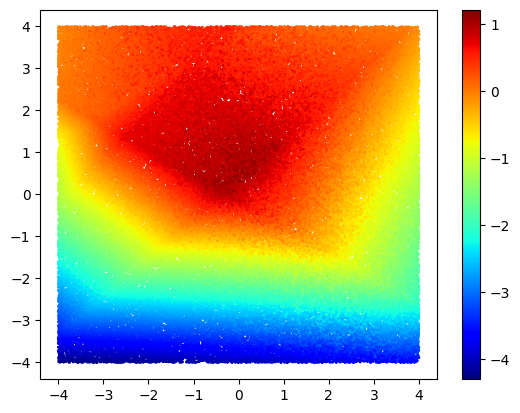

In [756]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Plot...
plt.scatter(X_val[:,0], X_val[:,1], c=y_pred, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.savefig('100_iter_adabeleif.png')
plt.show()


In [765]:
#train on small steps, run on bigger steps?
env = DubinsCarEnv()
state = env.reset()
gamma = 0.9
traj = []
done = False
max_iter = 200
counter = 0
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for a in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, a, update_env=False)
        estimate = forward(X=next_state, params=params)
        value = reward + gamma*estimate[0]
        print('estimate', value)
        print('state:',next_state)

        possible_actions.append(estimate[0])
        #possible_actions.append(reward)
    action = np.argmax(np.array(possible_actions))
    print(action, possible_actions)
    traj.append(state)
    state, reward, done, _ = env.step(action=action, update_env=True)
    env.render()
    print(counter)
    
env.make_gif()

/home/apraka15/Documents/Projects/Reach-Avoid/gym-examples/.env/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


estimate
state: [ 1.2516431  3.9330294 -0.5591191]
estimate
state: [ 1.2516431   3.9330294  -0.03511912]
estimate
state: [1.2516431  3.9330294  0.48888087]
2 [Array(0.13614273, dtype=float32), Array(0.13246727, dtype=float32), Array(0.13749528, dtype=float32)]
1
estimate
state: [1.2516431  3.9330294  0.46002454]
estimate
state: [ 1.2516431   3.9330294  -0.79845643]
estimate
state: [1.2516431 3.9330294 0.6181591]
1 [Array(0.13721848, dtype=float32), Array(0.14950824, dtype=float32), Array(0.13873577, dtype=float32)]
2
estimate
state: [1.2516431 3.9330294 2.3026662]
estimate
state: [1.2516431 3.9330294 3.0488374]
estimate
state: [ 1.0525028  3.9515538 -2.710348 ]
1 [Array(0.29853606, dtype=float32), Array(0.39790487, dtype=float32), Array(0.27142334, dtype=float32)]
3
estimate
state: [0.8533625 3.9700782 2.5248375]
estimate
state: [0.8533625 3.9700782 3.0488374]
estimate
state: [ 0.8533625  3.9700782 -2.710348 ]
1 [Array(0.37313342, dtype=float32), Array(0.44291544, dtype=float32), Array

In [610]:
xt = np.array(traj)[:,0]
yt = np.array(traj)[:,1]
print(len(xt), len(yt))

500 500


In [611]:
xt

array([-1.6476096, -1.5068904, -1.5946231, -1.6945956, -1.7799802,
       -1.8278639, -1.8253971, -1.7732418, -1.6853938, -1.5854273,
       -1.5001683, -1.4524962, -1.4552037, -1.5075643, -1.595527 ,
       -1.695487 , -1.78062  , -1.8280804, -1.8251323, -1.7725666,
       -1.6844895, -1.5845366, -1.4995302, -1.452282 , -1.4554709,
       -1.5082413, -1.5964321, -1.6963773, -1.7812566, -1.8282924,
       -1.8248627, -1.7718879, -1.6835837, -1.5836468, -1.4988952,
       -1.452072 , -1.4557424, -1.5089213, -1.5973382, -1.6972663,
       -1.7818899, -1.8285002, -1.8245891, -1.7712064, -1.6826773,
       -1.5827585, -1.4982635, -1.4518664, -1.456018 , -1.5096042,
       -1.5982451, -1.6981539, -1.7825198, -1.8287034, -1.8243111,
       -1.7705218, -1.6817696, -1.5818715, -1.4976351, -1.4516653,
       -1.4562979, -1.5102898, -1.5991523, -1.6990393, -1.7831463,
       -1.8289031, -1.824031 , -1.7698375, -1.6808653, -1.58099  ,
       -1.497013 , -1.4514694, -1.4565809, -1.5109757, -1.6000

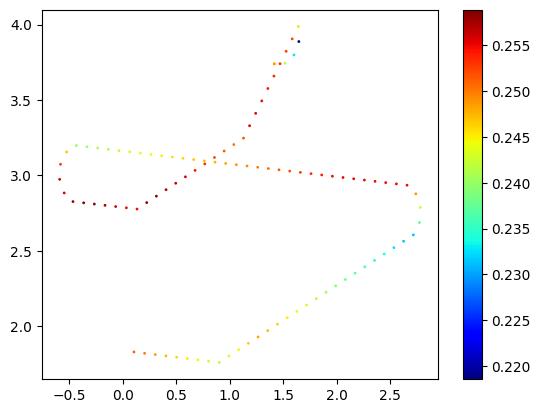

In [688]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
t = np.array([traj])
yp = [forward(X=x, params=params) for x in t]

# Plot...
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], c=yp, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()
#plt.savefig('500_iter.png')

In [618]:
yp

[Array([94.60541  ,  1.516793 ,  1.7196465,  1.9172227,  2.1065784,
         2.286975 ,  2.4600792,  2.6295147,  2.7998886,  2.9755576,
         3.1594563,  3.3523116,  3.5524461,  3.7562299,  3.9590538,
         4.1565647,  4.3458376,  4.5261564,  4.6992083,  4.8686304,
         5.039035 ,  5.214769 ,  5.3987503,  5.591684 ,  5.791871 ,
         5.9956675,  6.1984606,  6.3959064,  6.585097 ,  6.765337 ,
         6.9383364,  7.1077466,  7.2781816,  7.453981 ,  7.6380453,
         7.831056 ,  8.031296 ,  8.235105 ,  8.437867 ,  8.635247 ,
         8.824354 ,  9.004517 ,  9.177465 ,  9.346862 ,  9.517328 ,
         9.693193 ,  9.877341 , 10.07043  , 10.2707205, 10.474542 ,
        10.677273 , 10.874588 , 11.063612 , 11.243697 , 11.416593 ,
        11.5859785, 11.756475 , 11.932407 , 12.116637 , 12.309803 ,
        12.510145 , 12.713977 , 12.916676 , 13.113924 , 13.302864 ,
        13.482872 , 13.655716 , 13.825089 , 13.995618 , 14.171613 ,
        14.3559265, 14.54917  , 14.749562 , 14.9

In [689]:
forward(X=np.array([0,0,0]), params=params) 

Array([0.23673654], dtype=float32)